In [1]:
import pandas as pd
import ray
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go
from itertools import combinations
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                    StratifiedKFold, StratifiedShuffleSplit,
                                    cross_val_score)
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, classification_report
from imblearn.ensemble import BalancedRandomForestClassifier
import numpy as np
import joblib
from pandarallel import pandarallel
from sklearn.preprocessing import LabelEncoder, StandardScaler
import re

2024-04-11 17:07:31.812704: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 17:07:31.856254: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 17:07:32.084695: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 17:07:32.084719: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 17:07:32.086196: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [2]:
def busqueda(expression,column,name=None):
    if column is np.nan:
        return np.nan
    m = re.search(expression,column)
    if m == None:
        return np.nan
    if name != None:
        return name
    else :
        return m.group(0)

In [148]:
ls /home/nicolas/nico/Data/Masivas/23_01_2024/

Gaia_Brither_than_16G_internalmatch5arcsec.csv  skiff_completo.csv
plots_density/                                  Skiff_Prep_2arcsec.csv
plots_noDensity/                                ZariDR3_2arcscSkiff.csv
results/                                        ZariDR3_Prep_2arcscSkiff.csv


In [153]:
df_1 = pd.read_csv("/home/nicolas/nico/Data/Masivas/23_01_2024/ZariDR3_2arcscSkiff.csv")
skiff = df_1[["source_id","skiff_type",'Bibcode','GroupID_skiff']].astype(str)

In [154]:
#skiff['skiff_type'] = skiff['SpType'].replace('nan', np.nan)
#skiff['Bibcode'] = skiff['Bibcode'].replace('nan', np.nan)
#skiff['GroupID'] = skiff['GroupID'].replace('nan', np.nan)

In [155]:
skiff = skiff.loc[skiff['skiff_type'].notna()]

In [156]:
skiff["skiff_mk"] = skiff.apply(lambda row: busqueda(r"^(?!.*[+/])[a-zA-Z]\d+(?:\.\d+)?",row["skiff_type"]),axis=1)

In [157]:
skiff.loc[(skiff['skiff_mk'].isna())&(skiff['skiff_type'].str[:2]=='em'),'skiff_mk'] = 'em_WR_Be'
skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda(r"WR|WN|WC", row["skiff_type"],'em_WR_Be'), axis=1)
skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda(r"Be", row["skiff_type"],'em_WR_Be'), axis=1)
skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda(r"OB", row["skiff_type"]), axis=1)

In [158]:
skiff.loc[(skiff['skiff_mk'].isna())&(skiff['skiff_type'].str[0]=='h'),'skiff_mk'] = skiff.loc[(skiff['skiff_mk'].isna())&(skiff['skiff_type'].str[0]=='h')]['skiff_type'].str[1:3]

In [159]:
def busqueda_2(pattern, string, default=None):
    match = re.search(pattern, string)
    if match:
        return match.group(1)  # Retornamos el primer grupo de captura
    return default

skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda_2(r"^(.*?)(?=(V|IV|III|II|Ia|Ib|Iab)(?:/(V|IV|III|II|Ia|Ib|Iab))?$)", row["skiff_type"]), axis=1)


In [160]:
skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda(r"^(O|B|A|F|G|K|M)$", row["skiff_type"]), axis=1)


In [161]:
skiff.loc[(skiff['skiff_type']=='Ofe'),'skiff_mk'] = 'em_WR_Be'

In [162]:
skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda(r"e", row["skiff_type"],'em_WR_Be'), axis=1)


In [163]:
skiff.loc[skiff['skiff_mk'].isna(),'skiff_mk'] = skiff.loc[skiff['skiff_mk'].isna()].apply(lambda row: busqueda(r"^(O|B|A|F|G|K|M)(\d*(\.\d*)?)?(\/(\d*(\.\d*)?)?)?", row["skiff_type"]), axis=1)

In [164]:
skiff_mk = skiff.loc[(skiff['skiff_mk']!='em_WR_Be')&(skiff['skiff_mk']!='OB')&(skiff['skiff_mk'].notna())]

In [165]:
#correccion de las regular expression que dejaban tipos espectrales de la forma 
#O2/B0 --> O2/
correccion = skiff_mk.loc[skiff_mk["skiff_mk"].str[-1] =="/"].apply(lambda row: busqueda(r"[a-zA-Z]\d*(?:\.\d+)?/[a-zA-Z]\d*(?:\.\d+)?", row["skiff_type"]), axis=1)
skiff_mk.loc[skiff_mk["skiff_mk"].str[-1] =="/","skiff_mk"] = correccion

In [166]:
skiff_mk['skiff_mk'] = skiff_mk['skiff_mk'].str.replace('.', '')

/tmp/ipykernel_7868/2992802417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skiff_mk['skiff_mk'] = skiff_mk['skiff_mk'].str.replace('.', '')


In [167]:
replace_map = {
    'O': '0.',
    'B': '1.',
    'A': '2.',
    'F': '3.',
    'G': '4.',
    'K': '5.',
    'M': '6.'
}

In [168]:
skiff_mk['skiff_mk'] = skiff_mk['skiff_mk'].replace(replace_map, regex=True)


/tmp/ipykernel_7868/2936214468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skiff_mk['skiff_mk'] = skiff_mk['skiff_mk'].replace(replace_map, regex=True)


In [169]:
import re

def extract_first_float(s):
    match = re.search(r"(\d{1,2}(?:\.\d{1,2})?)", s)
    return float(match.group()) if match else None

s = '0.97Ib + 0.9'
number = extract_first_float(s)
print(number)


0.97


In [170]:
skiff_mk = skiff_mk[skiff_mk['skiff_mk'].str.split('/').str[0].str.len() !=1].reset_index(drop=True)

In [171]:
n1 = skiff_mk['skiff_mk'].str.split('/').str[0].reset_index(drop=True)

In [172]:
n1 = pd.DataFrame(n1).apply(lambda row: busqueda(r'(?<!\S)\d+\.\d*(?!\S)',row["skiff_mk"]),axis=1)  


In [173]:
n1 = n1.loc[n1.notna()]
#skiff_mk = skiff_mk.loc[n1.index]

In [174]:
n1 = n1.astype("str").apply(extract_first_float)

In [175]:
entero = n1.astype(str).str.split('.').str[0]
decimal = n1.astype(str).str.split('.').str[1]

In [176]:
n2 = skiff_mk['skiff_mk'].str.split('/').str[1].replace(np.nan,0).replace('',0).astype(str).reset_index(drop=True)

In [177]:
decimal  = '0.'+decimal
n2  = '0.'+n2

In [178]:
n2 = n2.astype(str).apply(extract_first_float)
decimal = decimal.astype(str).apply(extract_first_float)

In [179]:
n2.loc[n2 > 0] = n2.loc[n2 > 0] / 2
decimal.loc[n2 > 0] = decimal.loc[n2 > 0] / 2


In [180]:
skiff_mk.loc[decimal.index,'label'] = entero.astype(int) + (decimal + n2)

In [181]:
correccion_00 = skiff_mk.loc[skiff_mk["label"]==0.0].apply(lambda row: busqueda(r"O(?:N|C)?\d*(?:\.\d+)?",row["skiff_type"]),axis=1)

In [182]:
correccion_00 = correccion_00.str.replace("N","").str.replace("C","").str.replace(".","").str.replace("O","0")

In [183]:
correccion_00 = correccion_00.str.replace(r'^(0)', r'\1.', regex=True)

In [184]:
 skiff_mk.loc[skiff_mk["label"]==0.0,"label"] = pd.to_numeric(correccion_00)

In [185]:
import numpy as np

# Define los posibles valores
values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Selecciona las filas donde la longitud de 'skiff_type' es 1
mask = skiff_mk['skiff_type'].str.len() == 1

# Suma el valor en 'skiff_mk' con un valor aleatorio de 'values' y asigna el resultado a 'label'
skiff_mk.loc[mask, 'label'] = skiff_mk.loc[mask, 'label'] + np.random.choice(values, size=sum(mask))



In [186]:
skiff_mk["year"] = skiff_mk.apply(lambda row: busqueda(r"\d{4}",row["Bibcode"]),axis=1)  

In [187]:
skiff_mk["arxiv"] = skiff_mk.apply(lambda row: busqueda(r"arXiv",row["Bibcode"]),axis=1)  

In [188]:
skiff_mk.loc[skiff_mk["arxiv"].notna(),"year"] = "20" + skiff_mk.loc[skiff_mk["arxiv"].notna()]["year"].astype("str").str[:2]

In [189]:
skiff_mk["year"] = pd.to_numeric(skiff_mk["year"],errors="coerce")

In [190]:
stars_unicas = skiff_mk.loc[skiff_mk["GroupID_skiff"].isna()]
star_no_unicas = skiff_mk.loc[skiff_mk["GroupID_skiff"].notna()]

In [191]:
star_no_unicas_sp = star_no_unicas.groupby("GroupID_skiff")["skiff_type"].unique().reset_index()

In [192]:
star_no_unicas_sp = star_no_unicas_sp.rename(columns={"skiff_type":"skiff_type_list"})

In [193]:
star_no_unicas = star_no_unicas.merge(star_no_unicas_sp,how="left",on="GroupID_skiff")

In [194]:
# Calcula la desviación estándar dentro de cada grupo
std_by_group = star_no_unicas.groupby("GroupID_skiff")["label"].transform("std")

# Agrega la columna al DataFrame
star_no_unicas["std_sp"] = std_by_group

In [195]:
star_no_unicas = star_no_unicas.loc[(star_no_unicas["std_sp"]<0.5)|(star_no_unicas["std_sp"].isna())]

In [196]:
mean_by_group = star_no_unicas.groupby("GroupID_skiff")["label"].transform("mean")

# Agrega la columna al DataFrame
star_no_unicas["label"] = mean_by_group

In [197]:
star_no_unicas = star_no_unicas.sort_values(by="year",ascending=False).drop_duplicates(subset="GroupID_skiff",keep='first')

In [198]:
skiff_mk = pd.concat([star_no_unicas,stars_unicas])

In [199]:
skiff_mk

,source_id,skiff_type,Bibcode,GroupID_skiff,skiff_mk,label,year,arxiv,skiff_type_list,std_sp
39845,429451138534730368,B5/7,2022A&A...657A..62K,10782.0,1.5/7,1.737500,2022,NaN,"[B5/7, B, B8pHgMn, B8IV, B6III, A0III, B7III]",0.140789
12737,1915667396702502400,B5/7,2022A&A...657A..62K,3325.0,1.5/7,1.675000,2022,NaN,"[B7, B7III, B5/7]",0.050000
20941,4289988746025821824,B3/4,2022A&A...657A..62K,5574.0,1.3/4,1.283333,2022,NaN,"[B3/4, B3III, B2IV]",0.076376
4129,458375235013296000,B3/4,2022A&A...657A..62K,1053.0,1.3/4,1.175000,2022,NaN,"[B1.5Ia, B1I, B2Ia, B1Ia, B0III, B3I, B3/4]",0.094147
12772,2060614983816364416,B5/7,2022A&A...657A..62K,3334.0,1.5/7,1.466667,2022,NaN,"[B, B5IV, B6III, B3V:, B5, B5:, B5/7]",0.239792
...,...,...,...,...,...,...,...,...,...,...
15858,3326270132859096192,B8?,1918AnHar..92.....C,4193.0,1.8,1.800000,1918,NaN,[B8?],NaN
30893,4615535825249801216,F2,1918AnHar..92.....C,8287.0,3.2,3.200000,1918,NaN,[F2],NaN
36484,3103426824157375872,B8?,1918AnHar..92.....C,9821.0,1.8,1.800000,1918,NaN,[B8?],NaN
57595,3348834383502211328,A2,1918AnHar..92.....C,15626.0,2.2,2.200000,1918,NaN,[A2],NaN


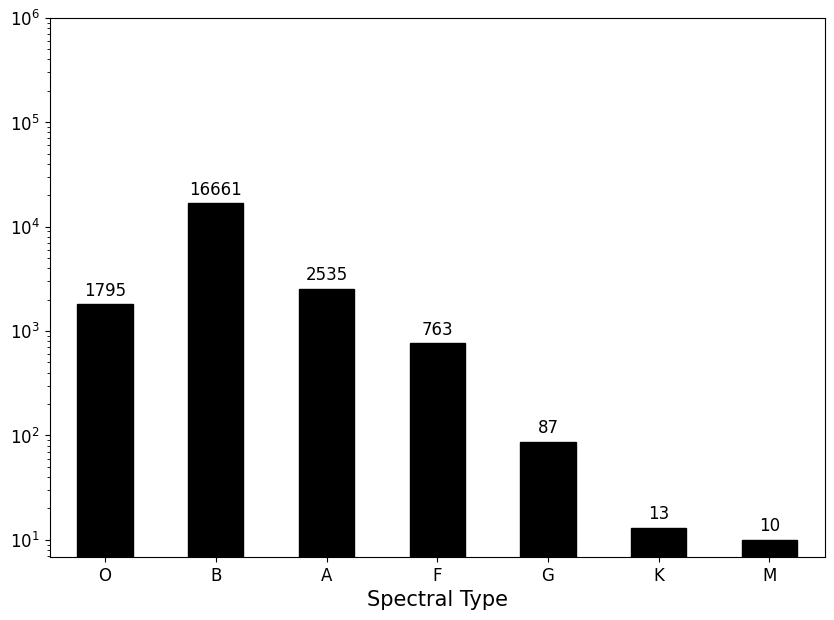

In [200]:
import pandas as pd

# Define the bin edges for categorization
bins = [0, 1, 2, 3, 4, 5, 6,7]

# Use pd.cut to categorize the stars into the defined bins
skiff_mk['binned'] = pd.cut(skiff_mk['label'], bins, labels=['O', 'B', 'A', 'F', 'G', 'K', 'M'])

# Count the number of occurrences in each bin
bin_counts = skiff_mk['binned'].value_counts().sort_index()

# We'll use the same sample data as before. Replace with your actual dataframe `skiff_mk['label']`.

# Calculate the percentage for each bin

# Plot the bar chart with a logarithmic scale
plt.figure(figsize=(10, 7))
ax = bin_counts.plot(kind='bar', color='black', edgecolor='black', logy=True)

# Adding labels and title
plt.xlabel('Spectral Type',size=15)
plt.tick_params(axis='both', which='major', labelsize=12)  # Cambia '12' al tamaño deseado
# Annotate the percentage on top of each bar
# Anotar el conteo de cada bin encima de las barras
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

# Configuración adicional del eje y y mostrar el gráfico
plt.gca().set_yticks([10, 100, 1000, 10000, 100000, 1000000])
ax.set_xticklabels(bin_counts.index, rotation=0)
plt.savefig("Skiff_27_dic.pdf", format='pdf', bbox_inches='tight')
plt.show()



In [201]:
skiff_mk.rename(columns={"label":"numeric_sp"},inplace=True)

In [73]:
df_1 = df_1.merge(skiff_mk[["Name","binned","numeric_sp","std_sp","skiff_type_list"]], on=['Name'], how='left')

In [76]:
df_1.loc[df_1["binned"]=="O"].to_csv("ALL_O_in_Skiff.csv",index=False)

In [77]:
df_1.to_csv("/home/nicolas/nico/Data/Masivas/data_correccion_zari/Skiff_Prep_2arcsec.csv",index=False)